# Train 3d CNN + Attention

## Setup

In [1]:
# Skip this cell if we are not on Google Colab
try:
    # Mount Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Specify working directory.
    FOLDERNAME = 'cs231n/project/'
    %cd /content/drive/My\ Drive/$FOLDERNAME

    # Ensure that the Python interpreter of the Colab VM can load python files from
    # within it.
    import sys
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
except ImportError as e:
    print("Not on Google Colab.")

Not on Google Colab.


## Load dataset and labels

In [2]:
import numpy as np
import os

#base_dir = '/content/drive/My Drive/cs231n/project/dataset/shaped_hrnet_data'
base_dir = '/home/ubuntu'

train_data = np.load(os.path.join(base_dir, 'train_data_pre12.npy'))
train_actions = np.load(os.path.join(base_dir, 'train_actions_pre12.npy'), allow_pickle=True)
train_labels = np.load(os.path.join(base_dir, 'train_labels_pre12.npy'))

val_data = np.load(os.path.join(base_dir, 'val_data_pre12.npy'))
val_actions = np.load(os.path.join(base_dir, 'val_actions_pre12.npy'), allow_pickle=True)
val_labels = np.load(os.path.join(base_dir, 'val_labels_pre12.npy'))

In [3]:
print('Training data shape: ', train_data.shape)
print('Training label shape: ', train_labels.shape)
print('Training action shape: ', train_actions.shape)
print('Train Label=1 ratio:', np.sum(train_labels) /train_labels.shape[0])
print('Validation data shape: ', val_data.shape)
print('Validation label shape: ', val_labels.shape)
print('Validation action shape: ', val_actions.shape)
print('Validation Label=1 ratio:', np.sum(val_labels) / val_labels.shape[0])

Training data shape:  (1007, 12, 224, 224, 3)
Training label shape:  (1007,)
Training action shape:  (1007,)
Train Label=1 ratio: 0.24925521350546176
Validation data shape:  (433, 12, 224, 224, 3)
Validation label shape:  (433,)
Validation action shape:  (433,)
Validation Label=1 ratio: 0.2517321016166282


In [4]:
mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
train_action_labels = [mapping[x] for x in train_actions]
val_action_labels = [mapping[x] for x in val_actions]

# One-hot encoding.
train_action_labels = np.eye(8)[train_action_labels] 
val_action_labels = np.eye(8)[val_action_labels] 

## 1. 3d CNN Model

### 1. Define model

In [7]:
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dropout, Dense, Flatten, concatenate, ZeroPadding3D
from keras import models, Model
from keras import Input
from keras.regularizers import l2

# from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
# from keras.layers.recurrent import LSTM
# from keras.models import Sequential, load_model
# from keras.optimizers import Adam, RMSprop
# from keras.layers.wrappers import TimeDistributed
# from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,
#     MaxPooling2D)

frames, channels, rows, columns = 12, 3, 224, 224
reg_lambda = 1e-3

input_model=Input(shape=(frames, rows, columns, channels))

# 3D Convolutional Model:
# model = models.Sequential()
# model.add(Input(shape=(frames, rows, columns, channels)))

# model.add(Conv3D(32, (3,3,3), activation='relu', kernel_regularizer=l2(reg_lambda)))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

# model.add(Conv3D(64, (3,3,3), activation='relu', kernel_regularizer=l2(reg_lambda)))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

# model.add(Conv3D(128, (3,3,3), activation='relu' , kernel_regularizer=l2(reg_lambda)))
# model.add(Conv3D(128, (3,3,3), activation='relu' , kernel_regularizer=l2(reg_lambda)))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))


# model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dense(64))
# model.add(Dropout(0.3))
# #model.add(Dense(1024))
# #model.add(Dropout(0.5))
# model.add(Dense(8, activation='softmax'))
# model.summary()


model = models.Sequential()
model.add(Input(shape=(frames, rows, columns, channels)))

# 1st layer group
model.add(Conv3D(32, (3, 3, 3), activation='relu', kernel_regularizer=l2(reg_lambda),
                 padding='same', name='conv1',
                 strides=(1, 1, 1)))
model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2),
                       padding='valid', name='pool1'))
# 2nd layer group
model.add(Conv3D(64, (3, 3, 3), activation='relu', kernel_regularizer=l2(reg_lambda),
                 padding='same', name='conv2',
                 strides=(1, 1, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                       padding='valid', name='pool2'))
# 3rd layer group
model.add(Conv3D(128, (3, 3, 3), activation='relu', kernel_regularizer=l2(reg_lambda),
                 padding='same', name='conv3a',
                 strides=(1, 1, 1)))
model.add(Conv3D(128, (3, 3, 3), activation='relu', kernel_regularizer=l2(reg_lambda),
                 padding='same', name='conv3b',
                 strides=(1, 1, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                       padding='valid', name='pool3'))
# 4th layer group
model.add(Conv3D(256, (3, 3, 3), activation='relu', kernel_regularizer=l2(reg_lambda),
                 padding='same', name='conv4a',
                 strides=(1, 1, 1)))
model.add(Conv3D(256, (3, 3, 3), activation='relu', kernel_regularizer=l2(reg_lambda),
                 padding='same', name='conv4b',
                 strides=(1, 1, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                       padding='valid', name='pool4'))

# # 5th layer group
# model.add(Conv3D(512, (3, 3, 3), activation='relu', kernel_regularizer=l2(reg_lambda),
#                  padding='same', name='conv5a',
#                  strides=(1, 1, 1)))
# model.add(Conv3D(512, (3, 3, 3), activation='relu', kernel_regularizer=l2(reg_lambda),
#                  padding='same', name='conv5b',
#                  strides=(1, 1, 1)))
# model.add(ZeroPadding3D(padding=(0, 1, 1)))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
#                        padding='same', name='pool5'))

model.add(Flatten())

# FC layers group
model.add(Dense(64, activation='relu', name='fc6'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 12, 224, 224, 32)  2624      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 12, 112, 112, 32)  0         
_________________________________________________________________
conv2 (Conv3D)               (None, 12, 112, 112, 64)  55360     
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 6, 56, 56, 64)     0         
_________________________________________________________________
conv3a (Conv3D)              (None, 6, 56, 56, 128)    221312    
_________________________________________________________________
conv3b (Conv3D)              (None, 6, 56, 56, 128)    442496    
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 3, 28, 28, 128)   

In [8]:
import keras
import tensorflow as tf
callbacks_list = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=50),
                  keras.callbacks.ModelCheckpoint(
                      filepath='3d_cnn_clean_model_v1',
                      monitor='val_loss',
                      save_best_only=True
                  ),
                  keras.callbacks.ReduceLROnPlateau(
                      monitor="val_loss", factor=0.1, patience=50
                  )]

from keras import optimizers

step = tf.Variable(0, trainable=False)
boundaries = [30, 60, 90, 120, 150, 180]
values = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)
learning_rate = learning_rate_fn(step)

optimizer_new=optimizers.Adam(lr=1e-4)
#optimizer_new=optimizers.SGD(lr=1e-4, momentum=0.9)
#optimizer_new=optimizers.SGD(lr=learning_rate)
model.compile(optimizer=optimizer_new,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

### 1.2 Train model

In [9]:
history = model.fit(train_data, train_action_labels,
                    validation_data=(val_data, val_action_labels),
                    batch_size=20, epochs=60,
                    callbacks=callbacks_list
                    )

Epoch 1/60
51/51 [==============================] - 224s 4s/step - loss: 2.7352 - accuracy: 0.1069 - val_loss: 2.5813 - val_accuracy: 0.1848
INFO:tensorflow:Assets written to: 3d_cnn_clean_model_v1/assets
Epoch 2/60
51/51 [==============================] - 191s 4s/step - loss: 2.5523 - accuracy: 0.1892 - val_loss: 2.4556 - val_accuracy: 0.1709
INFO:tensorflow:Assets written to: 3d_cnn_clean_model_v1/assets
Epoch 3/60
51/51 [==============================] - 185s 4s/step - loss: 2.4249 - accuracy: 0.2021 - val_loss: 2.3668 - val_accuracy: 0.1732
INFO:tensorflow:Assets written to: 3d_cnn_clean_model_v1/assets
Epoch 4/60
51/51 [==============================] - 184s 4s/step - loss: 2.3585 - accuracy: 0.2103 - val_loss: 2.3046 - val_accuracy: 0.1894
INFO:tensorflow:Assets written to: 3d_cnn_clean_model_v1/assets
Epoch 5/60
51/51 [==============================] - 183s 4s/step - loss: 2.2902 - accuracy: 0.1843 - val_loss: 2.2478 - val_accuracy: 0.1894
INFO:tensorflow:Assets written to: 3d_c

Epoch 49/60
51/51 [==============================] - 181s 4s/step - loss: 1.4491 - accuracy: 0.4333 - val_loss: 2.0433 - val_accuracy: 0.2864
Epoch 50/60
51/51 [==============================] - 181s 4s/step - loss: 1.4417 - accuracy: 0.4483 - val_loss: 2.1321 - val_accuracy: 0.3256
Epoch 51/60
51/51 [==============================] - 181s 4s/step - loss: 1.4587 - accuracy: 0.4515 - val_loss: 2.0231 - val_accuracy: 0.2794
Epoch 52/60
51/51 [==============================] - 181s 4s/step - loss: 1.3776 - accuracy: 0.4873 - val_loss: 2.0009 - val_accuracy: 0.2818
Epoch 53/60
51/51 [==============================] - 181s 4s/step - loss: 1.3762 - accuracy: 0.4784 - val_loss: 2.0595 - val_accuracy: 0.3048
Epoch 54/60
51/51 [==============================] - 181s 4s/step - loss: 1.3216 - accuracy: 0.4893 - val_loss: 2.1640 - val_accuracy: 0.2956
Epoch 55/60
51/51 [==============================] - 181s 4s/step - loss: 1.3352 - accuracy: 0.4628 - val_loss: 2.2557 - val_accuracy: 0.2818
Epoch 

### 1.3 Visualize Train/Valid accuracy & loss, confusion matrix

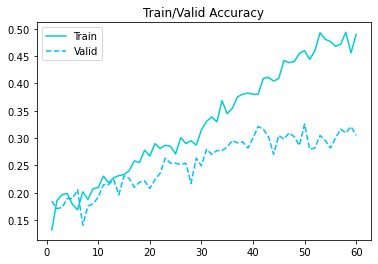

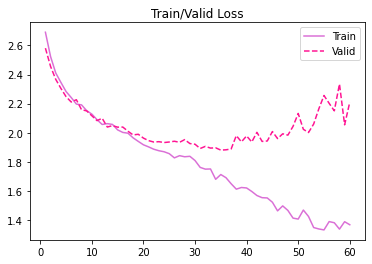

In [11]:
###Plot train/valid accuracy & loss
import matplotlib.pyplot as plt

acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs, acc, label = "Train", color = 'darkturquoise')
plt.plot(epochs, val_acc, label = "Valid", linestyle="--", color = 'deepskyblue')
plt.legend()
plt.title('Train/Valid Accuracy')
plt.show()

plt.plot(epochs, loss, label = "Train", color = 'orchid')
plt.plot(epochs, val_loss, label = "Valid", linestyle="--", color = 'deeppink')
plt.legend()
plt.title('Train/Valid Loss')
plt.show()

In [12]:
import keras
# Predictions on validation data:
val_preds = model.predict(val_data)
val_preds = np.argmax(val_preds,axis=1)
val_true = [mapping[x] for x in val_actions]

<AxesSubplot:>

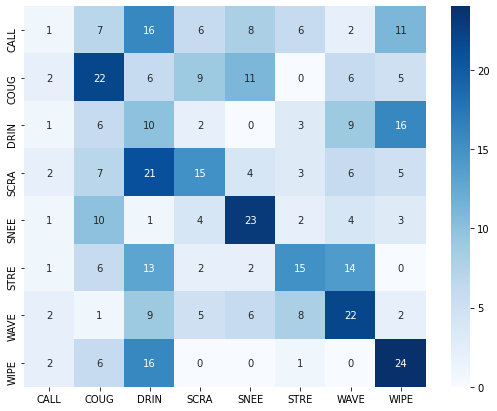

In [13]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=val_true, y_pred=val_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [14]:
# COUG:1, SNEE:4
val_true_bin = [x in (1, 4) for x in val_true]
val_preds_bin = [x in (1, 4) for x in val_preds]

<AxesSubplot:>

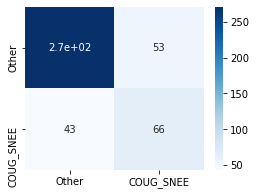

In [15]:
confusion_matrix = metrics.confusion_matrix(y_true=val_true_bin, y_pred=val_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [16]:
tn, fp, fn, tp = confusion_matrix.ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)

print('Prec.%', prec)
print('Rec.%', rec)
print('Acc.%', acc)

Prec.% 0.5546218487394958
Rec.% 0.6055045871559633
Acc.% 0.4074074074074074


### 1.4 Save model and loss history

In [17]:
###Save history
np.save(os.path.join(base_dir, "3d_cnn_clean_v1_history"), history.history)
###Save model
model.save(os.path.join(base_dir, "3d_cnn_clean_v1.h5"))   

#Load history:
#history = np.load(os.path.join(base_dir, "3d_cnn_clean_v1_history.npy"), allow_pickle=True)

#Load saved model:
#model = keras.models.load_model(os.path.join(base_dir, "3d_cnn_clean_v1.h5"))

In [ ]:
### 1.5 Evaluation on test data

In [18]:
#Load Test Data:
base_dir = '/home/ubuntu'
test_data = np.load(os.path.join(base_dir, 'test_data_pre12.npy'))
test_actions = np.load(os.path.join(base_dir, 'test_actions_pre12.npy'), allow_pickle=True)

In [19]:
# Predictions on test data:
test_preds = model.predict(test_data)
test_preds = np.argmax(test_preds,axis=1)
test_true = [mapping[x] for x in test_actions]

<AxesSubplot:>

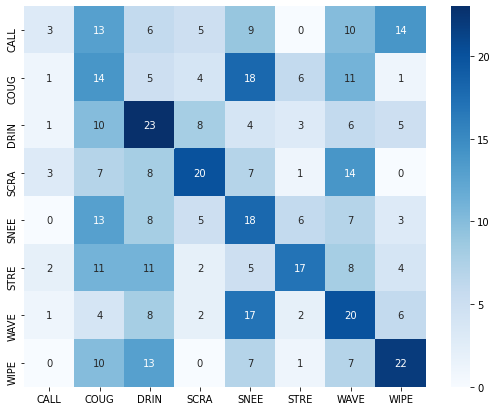

In [20]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=test_true, y_pred=test_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [21]:
# COUG:1, SNEE:4
test_true_bin = [x in (1, 4) for x in test_true]
test_preds_bin = [x in (1, 4) for x in test_preds]

<AxesSubplot:>

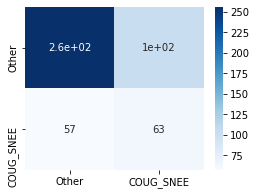

In [22]:
confusion_matrix = metrics.confusion_matrix(y_true=test_true_bin, y_pred=test_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [23]:
tn, fp, fn, tp = confusion_matrix.ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)

print('Prec.%', prec)
print('Rec.%', rec)
print('Acc.%', acc)

Prec.% 0.3772455089820359
Rec.% 0.525
Acc.% 0.28125
